In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

/blue/weishao/share/conda/envs/shao_lab/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /blue/weishao/share/conda/envs/shao_lab/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import numpy as np
import random
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.image as img
from matplotlib import offsetbox
from PIL import Image
import shutil 
import pandas as pd
import zipfile as zf
from tqdm.auto import tqdm
import yaml
import collections
import json
import random
import matplotlib.patches as patches
import pickle
import cv2
import time
import os
import copy
import math
from time import time
import warnings
%matplotlib inline
plt.style.use('bmh')
warnings.filterwarnings('ignore')

In [4]:
num_of_gpus = torch.cuda.device_count()
print(num_of_gpus)

5


In [5]:
train_df = pd.read_csv('Train.csv')
train_df = train_df.drop(columns=['m1x2','m1y2','m1x3','m1y3','m1x4','m1y4','m1x5','m1y5','m1x6','m1y6','m1x7','m1y7','m2x1','m2y1','m2x2','m2y2','m2x3','m2y3','m2x4','m2y4','m2x5','m2y5','m2x6','m2y6','behaviour'])
train_df = train_df.dropna(how='any')
train_df

,image,m1x1,m1y1,m2x7,m2y7
0,mouse070_frameno_1.jpg,487,119,449,57
1,mouse070_frameno_2.jpg,488,118,449,58
2,mouse070_frameno_3.jpg,491,105,455,59
3,mouse070_frameno_4.jpg,484,103,461,57
4,mouse070_frameno_5.jpg,482,102,465,56
...,...,...,...,...,...
121037,mouse001_frameno_21360.jpg,258,147,58,100
121038,mouse001_frameno_21361.jpg,258,148,59,99
121039,mouse001_frameno_21362.jpg,258,147,58,100
121040,mouse001_frameno_21363.jpg,258,147,58,100


In [6]:
def load_images_vectors(df,path):
    X , t =[],[]
    print("Found {} Images".format(len(os.listdir(path))))
    for i in range(len(df)):
        if df['image'][i]:
            img = cv2.imread(path+'/'+df['image'][i])
            X.append(np.array(img).reshape((3,330,600)))
            t.append(np.array([df['m1x1'][i],df['m1y1'][i],df['m2x7'][i],df['m2y7'][i]]))
        else:
            break
    print("Processed all the Images and their corresponding attributes")
    return np.array(X),np.array(t)          

In [7]:
X,t = load_images_vectors(train_df,os.path.join(os.getcwd(),'Images','train'))

Found 121043 Images
Processed all the Images and their corresponding attributes


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,t,shuffle=True,test_size=0.2,random_state=42)

### Data Loader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, vectors):
        self.data = torch.tensor(data).float()
        self.vectors = torch.tensor(vectors).float()

    def __len__(self):
        return len(self.vectors)

    def __getitem__(self, index):
        return self.data[index], self.vectors[index]

In [12]:
train_dataset = CustomDataset(X_train, y_train)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [14]:
test_dataset = CustomDataset(X_test, y_test)

In [15]:
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [16]:
def Multi_Gpu_Check(model,num_of_gpus):
    if num_of_gpus>1:
        model= nn.DataParallel(model).to(device)
    else:
        model= model.to(device)
    return model
        

In [17]:
def torch_integer_conv(arr):
    res=[]
    for i in arr:
        i = i .to("cpu")
        i = i.numpy()
        res.append(int(i))
    return np.array(res)

### Model Files

In [18]:
class ResNetRegression(nn.Module):
    def __init__(self, vectors=4):
        super(ResNetRegression, self).__init__()
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, vectors)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [19]:
def train_model(model,dataloader, criterion, optimizer, scheduler):
    model.train()
    
    running_loss = 0.0
    
    for images, vectors in dataloader:
        inputs = images.to(device)
        vectors = vectors.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, vectors)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item() * images.size(0)
        
    scheduler.step()
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [20]:
def validate_model(model,dataloader,criterion):
    model.eval()
    running_loss = 0.0
    
    with torch.no_grad():
        for images, vectors in dataloader:
            inputs = images.to(device)
            vectors = vectors.to(device)
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, vectors)

            # Print statistics
            running_loss += loss.item() * images.size(0)
            
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

### Hyperparamter Optimization

In [21]:
def model_optim(model, train_dataloader,val_dataloader,criterion, optimizer, scheduler, num_epochs=25):
    ep,loss1,loss2=[],[],[]
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000000.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        ep.append(epoch)
        # model training
        train_loss = train_model(model, train_dataloader, criterion, optimizer, scheduler)
        loss1.append(train_loss)
        
        #model validation
        val_loss = validate_model(model, val_dataloader, criterion)
        loss2.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")
        
        # saving a copy of best model parameters 
        if  val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
    print()    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Loss:{:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,np.average(np.array(loss2))

In [22]:
import time

In [23]:
model = ResNetRegression()

model = Multi_Gpu_Check(model,num_of_gpus)

criterion = nn.MSELoss()

In [24]:
ne=[30,100]
lrv = [0.0001,0.001]
ss =[7,9]
param=[]
sc=[]
print("\n Performing Custom Search For Best Parameters")
since = time.time()
for i in range(len(ne)):
    for j in range(len(lrv)):
        for k in range(len(ss)):
          tmp =(ne[i],lrv[j],ss[k])
          print("\n Training a model with a learning rate of {0},step size {1} and an epoch count of {2}".format(lrv[j],ss[k],ne[i]))
          param.append(tmp)
          optimizer = optim.Adam(model.parameters(), lr=lrv[j])
          step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=ss[k], gamma=0.1)
          model,loss = model_optim(model, train_dataloader,test_dataloader,criterion, optimizer, step_lr_scheduler, num_epochs=ne[i])
          sc.append(loss)
sc = np.array(sc)
blss = min(sc)
loc = np.where(np.array(sc)==blss)[0][0]
ne_v = param[loc][0]
lr_v = param[loc][1]
ss_v = param[loc][2]
time_elapsed = time.time() - since
print("The search for optimal parameters for the model has completed after:{:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
print("\nThe optimal parameters are given as follows - learning rate:{0},step size:{1} and a fixed number of epochs:{2}".format(lr_v,ss_v,ne_v))


 Performing Custom Search For Best Parameters

 Training a model with a learning rate of 0.0001,step size 7 and an epoch count of 30
Epoch 0/29
----------
Train Loss: 25412.3489, Test Loss: 11366.7133
Epoch 1/29
----------
Train Loss: 8913.9146, Test Loss: 5713.3394
Epoch 2/29
----------
Train Loss: 4077.4644, Test Loss: 2421.3801
Epoch 3/29
----------
Train Loss: 2079.0292, Test Loss: 1795.4051
Epoch 4/29
----------
Train Loss: 1199.4761, Test Loss: 1021.0042
Epoch 5/29
----------
Train Loss: 620.9659, Test Loss: 856.5736
Epoch 6/29
----------
Train Loss: 418.5686, Test Loss: 641.1652
Epoch 7/29
----------
Train Loss: 221.0135, Test Loss: 407.4668
Epoch 8/29
----------
Train Loss: 153.8847, Test Loss: 387.1932
Epoch 9/29
----------
Train Loss: 123.1987, Test Loss: 341.4463
Epoch 10/29
----------
Train Loss: 102.0919, Test Loss: 333.4056
Epoch 11/29
----------
Train Loss: 84.7424, Test Loss: 293.2051
Epoch 12/29
----------
Train Loss: 72.1523, Test Loss: 300.6382
Epoch 13/29
---------

### Final Model Training

In [25]:
def model_main(model, train_dataloader,val_dataloader,criterion, optimizer, scheduler, num_epochs=25):
    ep,loss1,loss2=[],[],[]
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000000.0
    
    for epoch in range(num_epochs):
        
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        ep.append(epoch)
        # model training
        train_loss = train_model(model, train_dataloader, criterion, optimizer, scheduler)
        loss1.append(train_loss)
        
        #model validation
        val_loss = validate_model(model, val_dataloader, criterion)
        loss2.append(val_loss)
        
        print(f"Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}")
        
        # saving a copy of best model parameters
        if  val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
    print()    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Test Loss:{:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,np.array(loss1),np.array(loss2),np.array(ep)
    

In [26]:
import time

In [27]:
model = ResNetRegression()

model = Multi_Gpu_Check(model,num_of_gpus)

criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=lr_v)

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=ss_v, gamma=0.1)

model,loss1,loss2,epochs = model_main(model,train_dataloader,test_dataloader,criterion, optimizer, step_lr_scheduler, num_epochs=ne_v)

Epoch 0/99
----------
Train Loss: 15577.8191, Test Loss: 13563.3988
Epoch 1/99
----------
Train Loss: 12153.6091, Test Loss: 9746.0213
Epoch 2/99
----------
Train Loss: 8169.8538, Test Loss: 5662.0214
Epoch 3/99
----------
Train Loss: 4609.9450, Test Loss: 3856.9034
Epoch 4/99
----------
Train Loss: 3042.3750, Test Loss: 2849.1130
Epoch 5/99
----------
Train Loss: 2132.5532, Test Loss: 3034.1090
Epoch 6/99
----------
Train Loss: 1466.1094, Test Loss: 1458.2555
Epoch 7/99
----------
Train Loss: 1081.8250, Test Loss: 1355.8676
Epoch 8/99
----------
Train Loss: 823.6949, Test Loss: 1104.8995
Epoch 9/99
----------
Train Loss: 428.9321, Test Loss: 611.4044
Epoch 10/99
----------
Train Loss: 325.8027, Test Loss: 685.1566
Epoch 11/99
----------
Train Loss: 282.7877, Test Loss: 562.2686
Epoch 12/99
----------
Train Loss: 245.7445, Test Loss: 575.7512
Epoch 13/99
----------
Train Loss: 221.3695, Test Loss: 509.0247
Epoch 14/99
----------
Train Loss: 199.8445, Test Loss: 488.8509
Epoch 15/99
---

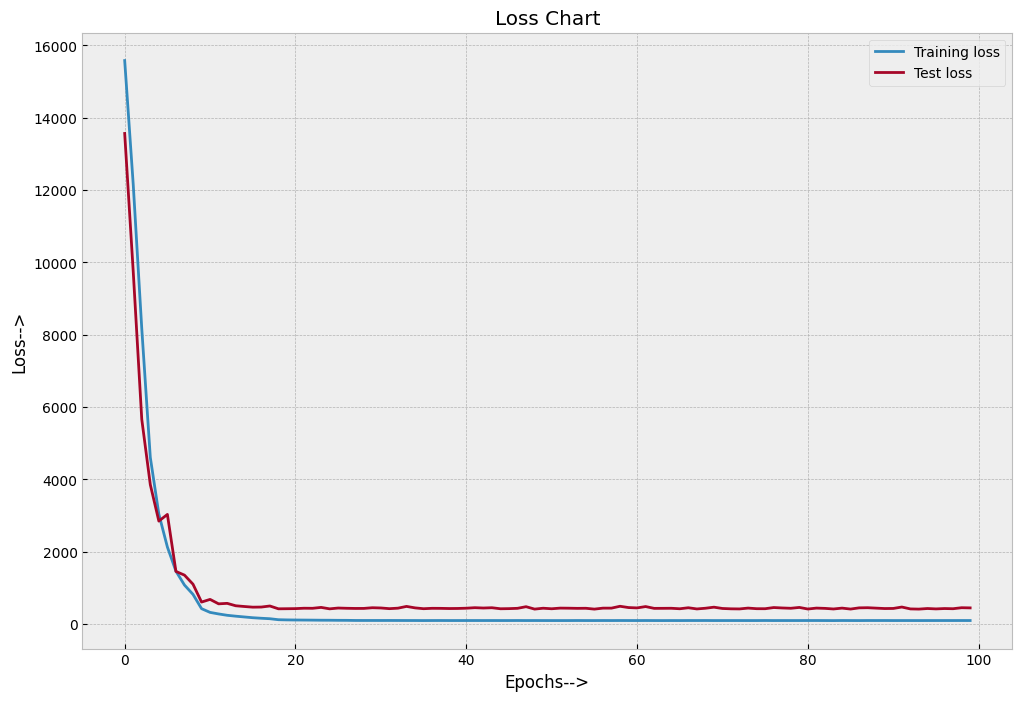

In [28]:
plt.figure(figsize =(12, 8))
plt.grid(visible=True)
plt.plot(epochs,loss1, label='Training loss')
plt.plot(epochs,loss2, label='Test loss')
plt.title('Loss Chart')
plt.xlabel('Epochs-->')
plt.ylabel('Loss-->')
plt.legend()
plt.savefig('Reg_Loss.png');

In [29]:
print('Finished Training')
device = torch.device("cpu")
model.to(device)
PATH = './MBAS-ResNet-101-Reg.pth'
torch.save(model, PATH)

Finished Training
